# Import Libraries

In [1]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 40.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.15.0
    Uninstalling wrapt-1.15.0:
      Successfully uninstalled wrapt-1.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2.13.0
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
 

In [2]:
import tensorflow as tf
import pathlib
import urllib.request
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers.legacy import RMSprop
import os
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import urllib.request
import zipfile
from keras.preprocessing import image


# print tensorflow version
print(tf.__version__)


# image dimension constants
IMAGE_HEIGHT = 250
IMAGE_WIDTH = 250
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
BATCH_SIZE = 32

2.14.0


# Custom Keras Callback

In [3]:
DESIRED_ACCURACY = 0.97

class KerasCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > DESIRED_ACCURACY:
            print(f'\nReached {DESIRED_ACCURACY}% accuracy so cancelling training!')
            self.model.stop_training = True

# Download Datasets

In [4]:
# download images
images_url = 'https://www.dropbox.com/scl/fi/d0va14gti266c7xlzx7gb/snacks_ds.zip?rlkey=bpjcow4mwrlcls7sry5kp8vka&dl=1'
filename = "snacks.zip"
dataset_dir = 'snacks'

urllib.request.urlretrieve(images_url, filename)

# extract to directory
zip_ref = zipfile.ZipFile(filename, 'r')
zip_ref.extractall(dataset_dir)
zip_ref.close()

# Generate Training and Validation Dataset

Found 8715 files belonging to 5 classes.
Using 6972 files for training.
Found 8715 files belonging to 5 classes.
Using 1743 files for validation.
['chippy', 'ding_dong', 'happy', 'mr_chips', 'nova']


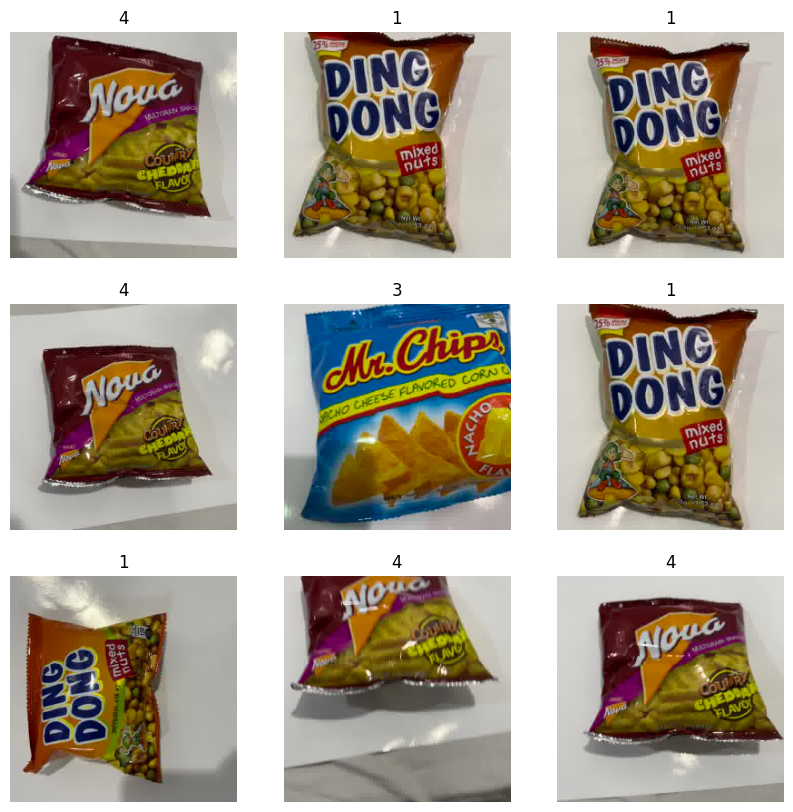

In [5]:
# training split
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# validation split
validation_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# print the labels / class names
class_names = train_ds.class_names
print(class_names)

# show few images from training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Create Test Dataset

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [6]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches // 5)
validation_ds = validation_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 44
Number of test batches: 11


# Configure the Dataset for Performance

Use buffered prefetching to load images from disk without having I/O become blocking.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [8]:
# resize and rescale
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
  tf.keras.layers.Rescaling(1./255)
])

# augmentaion
data_augmentation = tf.keras.Sequential([
  resize_and_rescale,
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomContrast(0.2),
  tf.keras.layers.RandomZoom(height_factor=(0.1, 0.2), width_factor=(0.1, 0.2))
])

# apply augmentation
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
validation_ds = validation_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

# Create the Model

In [9]:
model = tf.keras.models.Sequential([
  # This is the first convolution
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  # The second convolution
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  # The third convolution
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  # The fourth convolution
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  # Flatten the results to feed into a DNN
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.3),
  # 512 neuron hidden layer
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 124, 124, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 29, 29, 128)      

# Compile the Model

In [10]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

# Train the Model

In [11]:
# create the callback
callback = KerasCallback()

history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=100,
  steps_per_epoch=20,
  callbacks=[callback]
)

Epoch 1/100
20/20 [==============================] - 56s 2s/step - loss: 1.3518 - accuracy: 0.3625 - val_loss: 0.6008 - val_accuracy: 0.8275
Epoch 2/100
20/20 [==============================] - 34s 2s/step - loss: 0.6679 - accuracy: 0.7547 - val_loss: 0.3710 - val_accuracy: 0.9109
Epoch 3/100
20/20 [==============================] - 50s 3s/step - loss: 0.2895 - accuracy: 0.9016 - val_loss: 0.1523 - val_accuracy: 0.9605
Epoch 4/100
20/20 [==============================] - 33s 2s/step - loss: 0.2559 - accuracy: 0.9172 - val_loss: 0.1420 - val_accuracy: 0.9482
Epoch 5/100
20/20 [==============================] - 34s 2s/step - loss: 0.1749 - accuracy: 0.9297 - val_loss: 0.0974 - val_accuracy: 0.9662
Epoch 6/100
20/20 [==============================] - 29s 2s/step - loss: 0.0841 - accuracy: 0.9656 - val_loss: 0.1281 - val_accuracy: 0.9576
Epoch 7/100
20/20 [==============================] - ETA: 0s - loss: 0.0475 - accuracy: 0.9875
Reached 0.97% accuracy so cancelling training!
20/20 [=====

# Plot the Learning Curve

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


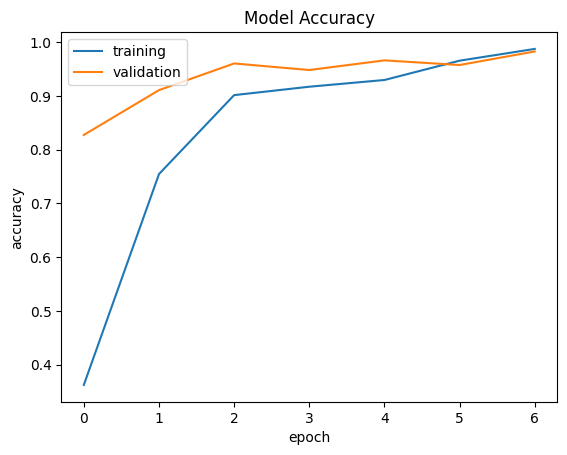

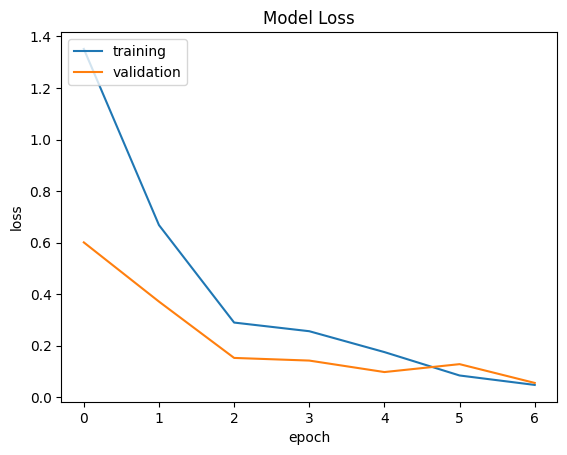

In [12]:
print(history.history.keys())

training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
vavlidation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# plot accuracy training vs. validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

# plot loss training vs. validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

# Evaluate Model

In [13]:
model.evaluate(test_ds)

11/11 [==============================] - 2s 104ms/step - loss: 0.0464 - accuracy: 0.9915


[0.04643036052584648, 0.9914772510528564]

# Save and Download Model

In [14]:
model.save('snacks_classifier.keras')
files.download('snacks_classifier.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Save Model as Saved Model

In [38]:
tf.keras.saving.save_model(model, 'snacks_classifier.h5', save_format='h5')
files.download('snacks_classifier.h5')

<ipython-input-38-e525b457a5c3>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.saving.save_model(model, 'snacks_classifier.h5', save_format='h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Convert the Model to TFJS

In [41]:
!tensorflowjs_converter --input_format=keras snacks_classifier.h5 tfjs/
!zip -r tfjs.zip tfjs
files.download('tfjs.zip')

2023-10-02 12:44:24.065104: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-02 12:44:24.065153: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-02 12:44:24.065184: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-02 12:44:25.062343: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
updating: tfjs/ (stored 0%)
updating: tfjs/model.json (deflated 85%)
updating: tfjs/group1-shard2of2.bin (deflated 8%)
updating: tfjs/group1-shard1of2.bin (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Test with Actual Images

In [29]:
LABELS = {
    0: 'chippy',
    1: 'Ding Dong',
    2: 'Happy',
    3: 'Mr. Chips',
    4: 'Nova'
}

uploaded = files.upload()

for fn in uploaded.keys():
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes)
  result = np.argmax(classes[0])
  result_label = LABELS[result]
  print(result_label)

Saving SM2047843-1.jpg to SM2047843-1 (1).jpg
1/1 [==============================] - 0s 18ms/step
[[0. 0. 1. 0. 0.]]
Happy
